In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz as gv
import pint
import pprint

In [2]:
ur = pint.UnitRegistry()
ur.setup_matplotlib(True)
Q = ur.Quantity

# parameters for the model
model = {
    'parameters': 70 * 10 ** 9,
    'n_layers': 80,
    'dim': 8192,
}

# parameters for the GPU
compute = {
    'mem': Q(80, 'GiB'),
    'mem_bandwidth': Q(2, 'TiB/s'),
    'flops': Q(310, 'THz')
}

# interconnect
net = {
    'bw': Q(5, 'Gbps'),
}

param_size = Q(2, 'bytes') # FP16

pprint.pprint(model)
pprint.pprint(compute)

{'dim': 8192, 'n_layers': 80, 'parameters': 70000000000}
{'flops': <Quantity(310, 'terahertz')>,
 'mem': <Quantity(80, 'gibibyte')>,
 'mem_bandwidth': <Quantity(2, 'tebibyte / second')>}


[2, 4, 5, 8, 10, 16, 20, 40, 80]
[<Quantity(0.131762458, 'gigabit / second')>, <Quantity(0.263524915, 'gigabit / second')>, <Quantity(0.329406144, 'gigabit / second')>, <Quantity(0.527049831, 'gigabit / second')>, <Quantity(0.658812288, 'gigabit / second')>, <Quantity(1.05409966, 'gigabit / second')>, <Quantity(1.31762458, 'gigabit / second')>, <Quantity(2.63524915, 'gigabit / second')>, <Quantity(5.27049831, 'gigabit / second')>]


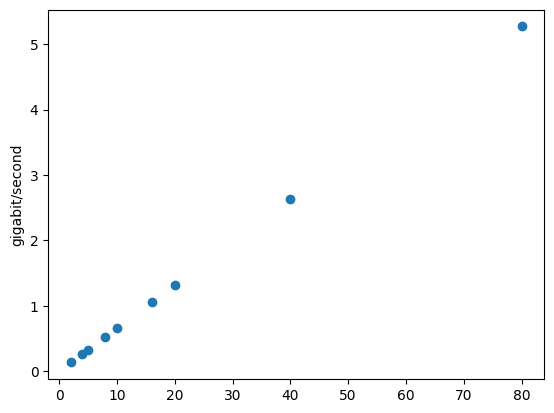

In [3]:
# let's say we want to split the task between N GPUs
# how much bandwidth do we need to keep the GPUs busy?

def bandwidth_required(N, batch_size=1):
  assert model['n_layers'] % N == 0

  model_slice_size = Q(2, 'bytes') * model['parameters'] / N 
  slice_processing_time = model_slice_size / compute['mem_bandwidth']

  # making sure that we're still memory bound
  assert (batch_size * (2 * model['parameters'] / N) / compute['flops']) < slice_processing_time

  slice_output_size = model['dim'] * batch_size * param_size
  mu = 1 / slice_processing_time
  return (mu * slice_output_size).to('Gbit/s')

# let's plot the bandwidth required for different numbers of GPUs
Ns = [2, 4, 5, 8, 10, 16, 20, 40, 80]
bandwidths = [bandwidth_required(N, batch_size=32) for N in Ns]

print(Ns)
print(bandwidths)
plt.scatter(Ns, bandwidths)


In [7]:
def bandwidth_required(N, batch_size=1):
  assert model['n_layers'] % N == 0

  model_slice_size = Q(2, 'bytes') * model['parameters'] / N 
  slice_processing_time = model_slice_size / compute['mem_bandwidth']

  # making sure that we're still memory bound
  assert (batch_size * (2 * model['parameters'] / N) / compute['flops']) < slice_processing_time

  output_transmission_time = model['dim'] * batch_size * param_size / net['bw']

  print(slice_processing_time.to('ms'), output_transmission_time.to('ms'))

bandwidth_required(4, 32)

15.916157281026244 millisecond 0.8388608000000002 millisecond
